<a href="https://colab.research.google.com/github/YuriiKlim/Projects/blob/Clothing_Classifier/clothing_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import os
import sys
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from urllib.request import urlopen
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import requests
from concurrent.futures import ThreadPoolExecutor
import random

# module_path = 'C:/Users/klimk/Desktop/Project/SegCloth.py'
# if module_path not in sys.path:
#     sys.path.append(module_path)
import SegCloth
from SegCloth import segment_clothing

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'


device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

torch.manual_seed(0)

In [7]:
df = pd.read_csv('C:/Users/klimk/Desktop/Nike/NikeOnly.csv')

In [8]:
df

,sku,Type,Color,Gender,Brand
0,DX6482-500,Sneakers,Purple,Women,Nike
1,FZ3088-100,Sneakers,White,Women,Nike
2,DM8974-401,Sneakers,Turquoise,Women,Nike
3,DV3950-105,Sneakers,Beige,Women,Nike
4,FD2292-102,Sneakers,White,Women,Nike
...,...,...,...,...,...
16309,DX1023-010,Tank Top,Black,Women,Nike
16310,FB8281-010,Tank Top,Black,Women,Nike
16311,FB4629-821,Tank Top,Yellow,Women,Air Jordan
16312,FB7986-457,Tank Top,Blue,Women,Nike


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16314 entries, 0 to 16313
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sku     16314 non-null  object
 1   Type    16314 non-null  object
 2   Color   16312 non-null  object
 3   Gender  16314 non-null  object
 4   Brand   16314 non-null  object
dtypes: object(5)
memory usage: 637.4+ KB


In [10]:
type_counts = df['Type'].value_counts()
type_counts

Type
T-shirt              3063
Sneakers             2241
Shorts               1730
Hoodie               1430
Pants                1425
Longsleeve           1309
Tank Top              987
Jacket                604
Sweatshirt            503
Sweater               472
Leggings              462
Polo                  419
Top                   345
Football Boots        298
Track Jacket          189
Full-zip Hoodie       187
Shirt                 119
Slippers              116
Football Sneakers      91
Skirt                  89
Vest                   87
Dress                  73
Puffer jacket          38
Parka                  37
Name: count, dtype: int64

In [11]:
type_counts = df['Color'].value_counts()
type_counts

Color
Black               3617
White               2172
Blue                1898
Grey                1437
Beige                868
                    ... 
Green/Pink             1
Pink/Beige             1
Brown/Olive            1
Yellow/Turquoise       1
Light-Blue/Grey        1
Name: count, Length: 189, dtype: int64

In [12]:
# data_dir = 'C:/Users/klimk/Desktop/Nike/main'

# def load_image(file_name):
#     file_path = os.path.join(data_dir, file_name + '.jpg')
#     if os.path.exists(file_path):
#         image = Image.open(file_path)
#         return image
#     else:
#         return None

In [13]:
img_size = 224

In [14]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

In [31]:
import cv2
from ultralytics import YOLO

class PhotoProcessing:
    def __init__(self, yolo_model_path='yolov8n.pt', data_dir='C:/Users/klimk/Desktop/Nike/main', output_size=(800, 800)):
        self.model = YOLO(yolo_model_path)
        self.data_dir = data_dir
        self.output_size = output_size
        self.processed_images = {}
        self.person_class_id = self._get_person_class_id()

    def _get_person_class_id(self):
        # Отримання ID класу "person" з dict, який зберігає імена класів
        for class_id, class_name in self.model.names.items():
            if class_name == 'person':
                return class_id
        raise ValueError("Class 'person' not found in model classes")

    def load_image(self, file_name):
        file_path = os.path.join(self.data_dir, file_name + '.jpg')
        if os.path.exists(file_path):
            image = Image.open(file_path).convert("RGB")
            return image
        else:
            return None

    def resize_for_yolo(self, image):
        width, height = image.size
        new_width = (width // 32) * 32
        new_height = (height // 32) * 32
        resized_image = image.resize((new_width, new_height))
        return resized_image

    def process_image(self, image, sku):
        image_resized = self.resize_for_yolo(image)

        output_image_rgb = np.array(image_resized)
        output_image_tensor = torch.from_numpy(output_image_rgb).permute(2, 0, 1).float() / 255.0
        output_image_tensor = output_image_tensor.unsqueeze(0)  # Додавання batch dimension

        results = self.model(output_image_tensor)

        detections = results[0].boxes.data.cpu().numpy()

        # Перевірка, чи є на фото людина
        person_detected = any(int(detection[5]) == self.person_class_id for detection in detections)

        if person_detected:
            processed_image = self.apply_segcloth(image_resized)
        else:
            processed_image = self.apply_white_background(image_resized)

        processed_image = processed_image.resize(self.output_size)
        self.processed_images[sku] = processed_image

    def apply_segcloth(self, image):
        result = segment_clothing(img=image)
        return result

    def apply_white_background(self, image):
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        mask = np.zeros(image_cv.shape[:2], np.uint8)
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)
        rect = (10, 10, image_cv.shape[1] - 10, image_cv.shape[0] - 10)
        cv2.grabCut(image_cv, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        output_image = image_cv.copy()
        output_image[mask2 == 0] = [255, 255, 255]  # Білий фон

        output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        return Image.fromarray(output_image_rgb)

    def process_images(self, skus):
        for sku in skus:
            image = self.load_image(sku)
            if image is not None:
                self.process_image(image, sku)

    def get_processed_images(self):
        return self.processed_images

In [32]:
# Інтеграція з process_image_generator
def process_image_generator(skus, processor):
    processor.process_images(skus)
    processed_images = processor.get_processed_images()
    for sku in skus:
        if sku in processed_images:
            yield sku, processed_images[sku]


In [15]:
# def process_image_generator(skus):
#     for sku in skus:
#         image = load_image(sku)
#         if image is not None:
#             image = transform(image)
#             yield sku, image

In [ ]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Ініціалізація класу PhotoProcessing
processor = PhotoProcessing()

all_valid_skus = []

batch_size = 512
total_batches = len(df['sku']) // batch_size + 1

with ThreadPoolExecutor(max_workers=8) as executor:
    for i in tqdm(range(0, len(df['sku']), batch_size), desc="Processing Batches", total=total_batches):
        batch_skus = df['sku'][i:i + batch_size]

        # Використання нового генератора process_image_generator
        results = list(executor.map(lambda skus: list(process_image_generator(skus, processor)), [batch_skus]))

        for result in results:
            for sku, image in result:
                all_valid_skus.append(sku)

df = df[df['sku'].isin(all_valid_skus)].reset_index(drop=True)

sku_count = df['sku'].count()
print(f"Total valid SKUs: {sku_count}")


Processing Batches:   0%|                                                                       | 0/32 [00:00<?, ?it/s]


0: 832x800 (no detections), 177.2ms
Speed: 5.0ms preprocess, 177.2ms inference, 3.0ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 1 scissors, 97.5ms
Speed: 5.0ms preprocess, 97.5ms inference, 4.5ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 1 skateboard, 96.6ms
Speed: 6.0ms preprocess, 96.6ms inference, 9.0ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 (no detections), 83.5ms
Speed: 5.0ms preprocess, 83.5ms inference, 5.0ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 (no detections), 64.5ms
Speed: 6.0ms preprocess, 64.5ms inference, 3.0ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 (no detections), 64.7ms
Speed: 5.0ms preprocess, 64.7ms inference, 4.0ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 (no detections), 62.5ms
Speed: 6.0ms preprocess, 62.5ms inference, 3.0ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 1 tennis racket, 84.7ms
Speed: 5.0ms preprocess, 84.7ms inferen

In [16]:
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor

# all_valid_skus = []

# batch_size = 512
# total_batches = len(df['sku']) // batch_size + 1

# with ThreadPoolExecutor(max_workers=8) as executor:
#     for i in tqdm(range(0, len(df['sku']), batch_size), desc="Processing Batches", total=total_batches):
#         batch_skus = df['sku'][i:i + batch_size]
#         results = list(executor.map(process_image_generator, [batch_skus]))

#         for result in results:
#             for sku, image in result:
#                 all_valid_skus.append(sku)

# df = df[df['sku'].isin(all_valid_skus)].reset_index(drop=True)

# sku_count = df['sku'].count()
# print(f"Total valid SKUs: {sku_count}")

Processing Batches: 100%|██████████████████████████████████████████████████████████████| 32/32 [02:11<00:00,  4.10s/it]

Total valid SKUs: 16230


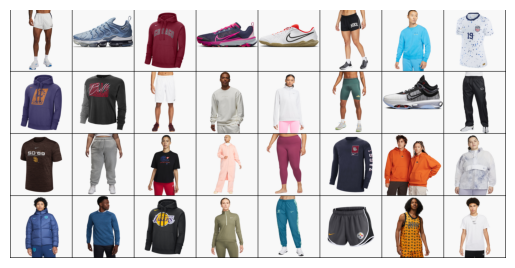

In [17]:
from torchvision.utils import make_grid

random_skus = random.sample(all_valid_skus, 32)

selected_images = [image for _, image in process_image_generator(random_skus)]

batch = torch.stack(selected_images)

grid = make_grid(batch).permute(1, 2, 0)

plt.imshow(grid)
plt.axis('off')
plt.show()

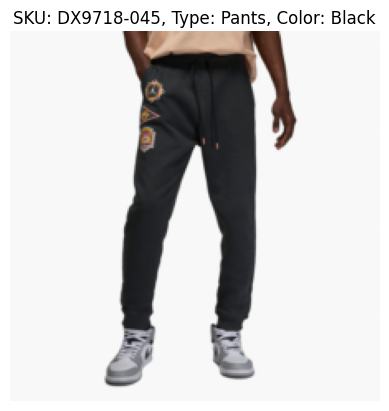

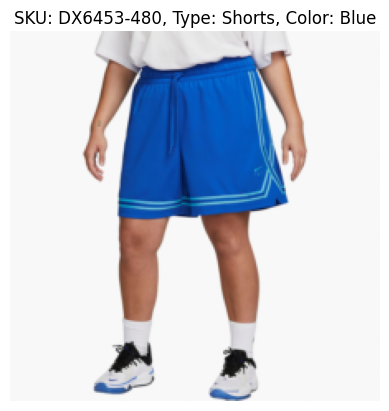

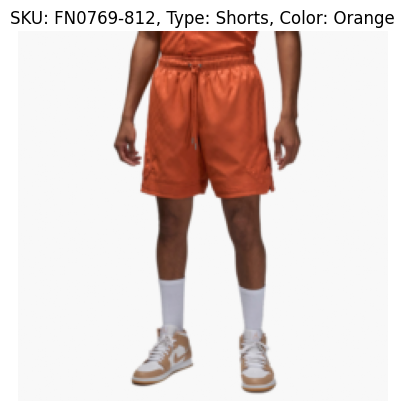

In [ ]:
random_skus = random.sample(all_valid_skus, 3)

for sku in random_skus:
    for _, image in process_image_generator([sku]):
        img = image.numpy()
        img = img.transpose((1, 2, 0))

        label_name = df[df['sku'] == sku]['Type'].values[0]
        color_name = df[df['sku'] == sku]['Color'].values[0]

        plt.imshow(img)
        plt.title(f"SKU: {sku}, Type: {label_name}, Color: {color_name}")
        plt.axis('off')
        plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['Type'] = label_encoder.fit_transform(df['Type'])

In [ ]:
from sklearn.model_selection import train_test_split

train_ratio = 0.8

grouped = df.groupby('Type')

train_list = []
val_list = []

for _, group in grouped:
    train, val = train_test_split(group, test_size=1 - train_ratio, random_state=42)
    train_list.append(train)
    val_list.append(val)

train_data = pd.concat(train_list).reset_index(drop=True)
val_data = pd.concat(val_list).reset_index(drop=True)

print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")

Train data size: 12972
Validation data size: 3258


In [ ]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import os

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.7950, 0.7757, 0.7759], std=[0.2544, 0.2742, 0.2743])
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7950, 0.7757, 0.7759], std=[0.2544, 0.2742, 0.2743])
])


class TransformDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if idx >= len(self.dataframe):
            raise IndexError(f"Index {idx} extends beyond the DataFrame")

        try:
            row = self.dataframe.iloc[idx:idx+1].squeeze()
        except KeyError as e:
            raise KeyError(f"Index access error {idx} in DataFrame: {e}")

        sku = row['sku']
        img_path = os.path.join(self.data_dir, f"{sku}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = row['Type']
        label = torch.tensor(label, dtype=torch.long)
        return image, label


train_dataset = TransformDataset(train_data, data_dir=data_dir, transform=train_transform)
val_dataset = TransformDataset(val_data, data_dir=data_dir, transform=test_transform)

print(f"Train Dataset size: {len(train_dataset)}")
print(f"Validation Dataset size: {len(val_dataset)}")

Train Dataset size: 12972
Validation Dataset size: 3258


In [ ]:
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)

In [ ]:
# means = []
# stds = []

# print("Calculation of mean values ​​and standard deviations for normalization:")
# for idx, (img, _) in enumerate(tqdm(val_dataset, desc="Calculating mean/std")):
#     if img.shape[0] == 3:
#         means.append(torch.mean(img, dim=[1, 2]).tolist())
#         stds.append(torch.std(img, dim=[1, 2]).tolist())
#     else:
#         filename = val_data.iloc[idx]['sku']
#         print(f"The image {filename} has an incorrect number of channels: {img.shape[0]}")

# mean = torch.mean(torch.tensor(means), dim=0)
# std = torch.mean(torch.tensor(stds), dim=0)

# mean, std

In [ ]:
from torchvision import models

inception = models.resnet152(pretrained=True)
inception

C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()

        resnet = models.resnet152(pretrained=True)

        for param in resnet.parameters():
            param.requires_grad = False

        in_features = resnet.fc.in_features

        resnet.fc = nn.Identity()

        self.feature_extractor = resnet

        self.fc1 = nn.Linear(in_features, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.feature_extractor(x)
        if isinstance(out, tuple):
            out = out[0]

        out = F.relu(self.fc1(out))
        out = self.dropout1(out)
        out = F.relu(self.fc2(out))
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

    def predict(self, data_loader, device='cpu'):
        self.eval()
        all_preds = []

        with torch.no_grad():
            for inputs in data_loader:
                inputs = inputs.to(device)
                outputs = self(inputs)
                preds = F.softmax(outputs, dim=-1)
                all_preds.append(preds.cpu().numpy())

        return np.concatenate(all_preds, axis=0)

model = TransferLearningClassifier(num_classes=len(train_data['Type'].unique())).to(device)

In [ ]:
from torchsummary import summary

summary(model, input_size=(3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
class_counts = df['Type'].value_counts()

total_samples = len(df)

class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

weights = torch.tensor([class_weights[cls] for cls in sorted(class_counts.index)], dtype=torch.float32).to(device)

weights

tensor([222.3288,  54.6465, 178.3517,  86.7914,  11.3576,  26.8709,  35.2061,
         12.4178,  11.4055, 438.6487,  38.7351, 427.1053, 143.6283,   9.4032,
        182.3596, 146.2162,   7.2944,  34.3856,  32.3952,   5.3109,  16.5275,
         51.8530,  85.8730, 186.5517], device='cuda:0')

In [ ]:
loss_fn = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, scheduler=None,
          metrics=None, metrics_name=None, epochs=20, device='cuda', task='regression', log_interval=1):
    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    model.to(device)

    start_time_train = time.time()

    for epoch in range(epochs):
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss'] + metrics_name}

        for batch in train_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    if func == roc_auc_score:
                        # Check if there are both classes present in y
                        if len(np.unique(y)) == 2:
                            history_train[name] += func(y, y_pred) * x.size(0)
                    else:
                        history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary':
                        y_pred_ = y_pred.round()
                    elif task == 'multiclass':
                        y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x = batch[0].to(device)
                y = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        if func == roc_auc_score:
                            # Check if there are both classes present in y
                            if len(np.unique(y)) == 2:
                                history_val['val_' + name] += func(y, y_pred) * x.size(0)
                        else:
                            history_val['val_' + name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary':
                            y_pred_ = y_pred.round()
                        elif task == 'multiclass':
                            y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_' + name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = end_time_epoch - start_time_epoch

        if epoch + 1 == 1 or (epoch + 1) % log_interval == 0 or epoch + 1 == epochs:
            print(f'Epoch {epoch + 1:4d} {total_time_epoch:4.0f}sec', end='\t')
            for name in history_train:
                print(f'{name}: {history[name][-1]:10.3g}', end='\t')
                print(f"val_{name}: {history['val_' + name][-1]:10.3g}", end='\t')
            print()

        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(history_val['val_loss'][-1])
            else:
                scheduler.step()

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='multiclass',
               log_interval=1)

Epoch    1  263sec	loss:       3.49	val_loss:       3.15	accuracy_score:     0.0168	val_accuracy_score:      0.144	
Epoch    2  263sec	loss:       3.15	val_loss:       3.13	accuracy_score:     0.0744	val_accuracy_score:      0.188	
Epoch    3  262sec	loss:       3.09	val_loss:       3.13	accuracy_score:      0.121	val_accuracy_score:      0.188	
Epoch    4  262sec	loss:       3.04	val_loss:       3.13	accuracy_score:      0.138	val_accuracy_score:      0.188	
Epoch    5  262sec	loss:       3.02	val_loss:       3.13	accuracy_score:      0.141	val_accuracy_score:      0.188	
Epoch    6  262sec	loss:       3.01	val_loss:       3.13	accuracy_score:      0.144	val_accuracy_score:      0.188	
Epoch    7  262sec	loss:          3	val_loss:       3.13	accuracy_score:      0.147	val_accuracy_score:      0.188	
Epoch    8  261sec	loss:       2.98	val_loss:       3.13	accuracy_score:      0.152	val_accuracy_score:      0.188	
Epoch    9  262sec	loss:       2.97	val_loss:       3.13	accuracy_score: